In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files

import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.legend_handler import HandlerLine2D


import cv2

import pandas as pd
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import keras.backend as K

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Download training data and pre-trained model
def setData():
  !mkdir data/

  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1yC87SJnkowEPZ3XoBZ0uQTbGUGmKJbs2' -O data/data.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1_rVIcU6sBRS321dwnTO3htf83C7p3jY3' -O data/model.h5

  !mkdir data/data
  !unzip data/data.zip -d data/data
  !mkdir data/data/train_aug
  !mkdir data/data/valid_resized
  !mkdir data/data/resized

**Model**

In [ ]:
# Load pre-trained model
def load_pre_trained_model(model_path):
  pre=keras.models.load_model(model_path)
  for layer in pre.layers:
    layer.tainable=True
  last_layer= pre.get_layer('mixed_7a')
  last_output=last_layer.output

  return last_output, pre


# Build regression layers
def architecture_1(last_output,pre,dropout_rate):
  x=layers.Flatten()(last_output)
  x=layers.Dense(1024)(x)
  x=layers.Dropout(dropout_rate)(x)
  x=layers.Dense(1)(x)

  return x

def architecture_2(last_output,pre,dropout_rate):
  x=layers.Flatten()(last_output)
  x=layers.Dense(1024)(x)
  x=layers.Dropout(dropout_rate)(x)
  x=layers.Dense(512)(x)
  x=layers.Dropout(dropout_rate)(x)
  x=layers.Dense(1)(x)

  return x



# Put 4 output layers
def configureLayers(last_output, pre, dropout_rate, loss_obj, arch_type):
  output1=arch_type(last_output,pre,dropout_rate)
  output2=arch_type(last_output,pre,dropout_rate)
  output3=arch_type(last_output,pre,dropout_rate)
  output4=arch_type(last_output,pre,dropout_rate)

  model=Model(pre.input,[output1,output2,output3,output4])
  model.compile(loss=loss_obj.loss_coord,
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                metrics=['acc'])
  
  return model


# Create model
def create_model(model, dropout_rate, loss_obj, arch_type):
  last_output, pre_trained_model= model
  return configureLayers(last_output,pre_trained_model,dropout_rate, loss_obj, arch_type)

In [ ]:
# Loss function
class loss(object):
  def __init__(self):
    # Loss function is loaded in each output
    # idx variable is used to indicate which output is currently being computed
    self.idx=0
  

  def loss_coord(self,y_true,y_pred):
    v=K.square(y_true[0][self.idx]- y_pred)

    self.idx=(self.idx+1)%4

    return v
  


**Data Process**

In [ ]:
# Resize images and save them. Return Panda dataframe, which contatins information about resized images.
# In 'path' folder, there are 2 sub folders, 'image' and 'label'. 
# 'images' and 'label' contain image files and xml files (annotation files) respectively.
# Since all the models used here has 350 * 350 * 3 input shape, I always pass 350 in 'size' argument
def dataProcess1(path,res_path,size):
  import math
  from imutils import paths
  from bs4 import BeautifulSoup

  # Load file names in 'image' folders
  imagelst = list(paths.list_images(path+'/image'))
  
  # Empty list, which will contain information about images and be turned into Panda dataframe
  data=[]
  
  # Iterate all the files in 'image' folder
  for fname in imagelst:
    
    # Load xml file corresponding to current image file
    filename=fname.split('/')[-1].split('.')[0]
    annotfpath=path+'/label/'+filename+'.xml'
    contents=open(annotfpath).read()
    soup = BeautifulSoup(contents, "html.parser")
    
    # np array of image file
    img=cv2.imread(fname)

    # Get coordinates of top left vertex and bottom right vertex of the ground truth box of current image
    xmin,ymin,xmax,ymax=int(soup.object.xmin.string),int(soup.object.ymin.string), int(soup.object.xmax.string), int(soup.object.ymax.string) 
    
    # Get width and height of current image
    width=img.shape[1]
    height=img.shape[0]

    # Resize the image and save in 'res_path'
    img=cv2.resize(img,(size,size))
    cv2.imwrite(res_path+'/'+fname.split('/')[-1],img)

    # Compute coordinates of a ground truth box of resized image
    x1,y1,x2,y2=size/width*xmin, size/height*ymin, size/width*xmax, size/height*ymax

    # Compute width, height, and coordinates of the center of a ground truth box of resized image
    x,y,w,h=(xmin+xmax)/2, (ymin+ymax)/2, xmax-xmin, ymax-ymin
    data.append([fname.split('/')[-1],width,height,x,y,w,h,x1,y1,x2,y2])

  # convert the list to Panda dataframe
  df=pd.DataFrame(data, columns=['filename','width','height','x','y','w','h','xmin','ymin','xmax','ymax'])

  return df

In [ ]:
# Data augmentation parameters
def random_aug(rotate, translate, shear):
  import random
  lst=[[(0,0),{'x':0,'y':0},(0,0),(1.0,1.0)],[(-random.randrange(rotate),random.randrange(rotate)), {'x':random.randrange(-translate,translate),'y':random.randrange(-translate,translate) },
                              (random.randrange(-shear,shear),random.randrange(-shear,shear)), (random.uniform(0.5,1),random.uniform(0.5,1))]   ]

  
  return [iaa.Fliplr(0.5), 
          iaa.Flipud(0.5),
          iaa.Affine(rotate=lst[random.randrange(2)][0],
                     translate_px=lst[random.randrange(2)][1],
                     scale=lst[random.randrange(2)][3],
                     shear=lst[random.randrange(2)][2])]


In [ ]:
# Load images in img_path and transform them
# img_path : folder contains images
# aug_path : folder to save augmented images
# df : folder contains xml files info about images in img_path
def dataAug(img_path,aug_path,df):

  # Load data augmentation parameters
  seq=iaa.Sequential(random_aug(65,70,25),random_order=True)

  # List to store information about augmented images
  data=[]

  for index, row in df.iterrows(): 
    # Filename of current image
    fname=row['filename']

    # Get coordinates of a bounding box of current image
    x_1,y_1,x_2,y_2=row['xmin'],row['ymin'], row['xmax'],row['ymax']

    # np array of current image
    img=cv2.imread(img_path+'/'+fname)

    # Bounding box of current image
    bbs = BoundingBoxesOnImage([
    BoundingBox(x1=x_1, y1=y_1,x2=x_2, y2=y_2)]
    , shape=img.shape)

    # Image augmentation
    img_aug, bbs_aug=seq(image=img, bounding_boxes=bbs)

    # Coordinates of a bounding box of augmented image
    xmin,ymin,xmax,ymax=bbs_aug.bounding_boxes[0].x1,  bbs_aug.bounding_boxes[0].y1,  bbs_aug.bounding_boxes[0].x2, bbs_aug.bounding_boxes[0].y2
    # Width, height, and coordinates of the center of a bounding box of augmented image
    x,y,w,h=(xmax+xmin)/2,(ymin+ymax)/2,xmax-xmin,ymax-ymin
    
    # Save the augmented image in 'aug_path'
    cv2.imwrite(aug_path+'/'+fname, img_aug)

    # Append info in the list
    data.append([fname,x,y,w,h,xmin,ymin,xmax,ymax])

  return pd.DataFrame(data, columns=['filename','x','y','w','h','xmin','ymin','xmax','ymax'])

In [ ]:
# Create Image Data Generator for 'xmin', 'ymin', 'xmax', 'ymax' output
def image_datagen1(path,df,size):
  train_datagen=ImageDataGenerator(rescale=1./255)

  train_generator=train_datagen.flow_from_dataframe(
      dataframe=df,
      directory=path,
      target_size=(size,size),
      x_col='filename',
      y_col=['xmin','ymin','xmax','ymax'],
      class_mode='raw',
      batch_size=20)
  return train_generator

In [ ]:
# Create Image Data Generator for 'x', 'y', 'width', 'height' output
def image_datagen2(path,df,size):
  train_datagen=ImageDataGenerator(rescale=1./255)

  train_generator=train_datagen.flow_from_dataframe(
      dataframe=df,
      directory=path,
      target_size=(size,size),
      x_col='filename',
      y_col=['x','y','w','h'],
      class_mode='raw',
      batch_size=20)
  return train_generator

**Train model**

In [ ]:
# Train model
# Return a list of histories
# model : Model
# df_train_resized : Panda dataframe of resized training data
# train_resized_path : Folder which contains resized training data
# aug_path : Folder to save augemnted data
# df_valid : Panda dataframe of resized valid data
# resized_valid_path : Folder which contains resized valid data
# num_epoh : A number of epoch to train
# size : Input shape
# cp_path : Folder to save checkpoints
# cp_num : A number to start checkpoint
# t_generator : Image Data Generator type. 
#               image_datagen1 or image_datagen2                   
def train(model, df_train_resized,train_resized_path,  aug_path, df_valid,resized_valid_path,num_epoch, size,cp_path,cp_num,t_generator):
  
  # List will contain histories
  log=[]


  # Create Image Data Generator
  train_generator=image_datagen1(train_resized_path, df_img,size)
  valid_generator=image_datagen1(resized_valid_path,df_valid, size)
  
  # Checkpoint
  cp_callback=keras.callbacks.ModelCheckpoint(cp_path+'/weights0.ckpt',
                                                save_weights_only=True,
                                                vebose=1)
  # Fit model
  history=model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=1,
      validation_data=valid_generator,
      validation_steps=len(valid_generator),
      callbacks=[cp_callback],
      verbose=2)
  
  # Add history of one epoch
  log.append(history)


  for i in range(num_epoch-1):
    print('cp : '+ str(cp_num+i))

    # Data augmentation
    df_aug=dataAug(train_resized_path,aug_path,df_img)
    # Create Image Data Generator
    train_generator=t_generator(aug_path, df_aug,size)
    cp_callback=keras.callbacks.ModelCheckpoint(cp_path+'/weights.'+str(cp_num+i)+'.ckpt',
                                                save_weights_only=True,
                                                vebose=1)
    # Fit model with augmented data generator
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=1,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[cp_callback],
        verbose=2)
    
    log.append(history)


  return log

**Set up data**

In [ ]:
# Download and unzip data
setData()

In [ ]:
# Pre_trained model path
model_path='drive/My Drive/files/model.h5'

In [ ]:
# Load pre trained model
pre_model=load_pre_trained_model(model_path)

In [ ]:
# Create a loss function object
losss=loss()

In [ ]:
# Create model
mm=create_model(pre_model,0.2,losss, architecture_2)

In [ ]:
# Resize training and valid data and create Panda dataframes 
size=350
df_img=dataProcess1('data/data/train','data/data/resized',size)
df_valid=dataProcess1('data/data/valid', 'data/data/valid_resized', size)

In [ ]:
# Create folder to save checkpoints
!mkdir cp

**Train model**

In [ ]:
# Train model and get history
history=train(mm,
              df_img,'data/data/resized',
              'data/data/train_aug',
              df_valid,'data/data/valid_resized',
              30,350,'cp',0,
              image_datagen2)

Found 1633 validated image filenames.
Found 461 validated image filenames.
82/82 - 193s - loss: 22842.3965 - dense_2_loss: 5328.4058 - dense_5_loss: 7036.2266 - dense_8_loss: 5130.4082 - dense_11_loss: 5347.3584 - dense_2_acc: 0.0000e+00 - dense_5_acc: 0.0000e+00 - dense_8_acc: 0.0000e+00 - dense_11_acc: 0.0000e+00 - val_loss: 20653.5449 - val_dense_2_loss: 2510.1396 - val_dense_5_loss: 6479.9248 - val_dense_8_loss: 4892.6895 - val_dense_11_loss: 6770.7910 - val_dense_2_acc: 0.0000e+00 - val_dense_5_acc: 0.0000e+00 - val_dense_8_acc: 0.0000e+00 - val_dense_11_acc: 0.0000e+00
cp : 0
Found 1633 validated image filenames.
82/82 - 193s - loss: 18403.3750 - dense_2_loss: 2003.1504 - dense_5_loss: 6251.6895 - dense_8_loss: 4641.9365 - dense_11_loss: 5506.6006 - dense_2_acc: 0.0000e+00 - dense_5_acc: 0.0000e+00 - dense_8_acc: 0.0000e+00 - dense_11_acc: 0.0000e+00 - val_loss: 81145.3281 - val_dense_2_loss: 2042.5922 - val_dense_5_loss: 6151.8589 - val_dense_8_loss: 29283.1094 - val_dense_11_lo

**Report graphs**

In [ ]:
# History to list
def history_to_list(history_list):
  result=[]
  loss=[]
  loss_1=[]
  loss_2=[]
  loss_3=[]
  loss_4=[]
  loss_val=[]
  loss_1_val=[]
  loss_2_val=[]
  loss_3_val=[]
  loss_4_val=[]
  for i in range(len(history_list)):
    tmp=list(history_list[i].history.values())
    #loss.append(tmp['loss'])
    #print(history_list[i].history)
    loss.append(tmp[0])
    loss_1.append(tmp[1])
    loss_2.append(tmp[2])
    loss_3.append(tmp[3])
    loss_4.append(tmp[4])
    loss_val.append(tmp[9])
    loss_1_val.append(tmp[10])
    loss_2_val.append(tmp[11])
    loss_3_val.append(tmp[12])
    loss_4_val.append(tmp[13])
  return [loss, loss_1,loss_2,loss_3,loss_4, loss_val, loss_1_val, loss_2_val, loss_3_val, loss_4_val]

# List to graph
def list_to_graph(lists):
  epochs=range(len(lists[0]))
  plt.ylim(0,100000)
  train1,=plt.plot(epochs,lists[0])
  valid1,=plt.plot(epochs,lists[5])
  plt.legend([(train1),(valid1)],['train','valid'])
  plt.title('Training and validation loss')
  plt.figure()


  epochs=range(len(lists[0]))
  plt.ylim(0,60000)
  train1,=plt.plot(epochs,lists[1])
  valid1,=plt.plot(epochs,lists[6])
  plt.legend([(train1),(valid1)],['train','valid'])
  plt.title('Training and validation loss of ouput 1')
  plt.figure()

  #epochs=range(len(lists[0]))
  plt.ylim(0,60000)
  train1,=plt.plot(epochs,lists[2])
  valid1,=plt.plot(epochs,lists[7])
  plt.legend([(train1),(valid1)],['train','valid'])
  plt.title('Training and validation loss of ouput 2')
  plt.figure()

  #epochs=range(len(lists[0]))
  plt.ylim(0,60000)
  train1,=plt.plot(epochs,lists[3])
  valid1,=plt.plot(epochs,lists[8])
  plt.legend([(train1),(valid1)],['train','valid'])
  plt.title('Training and validation loss of ouput 3')
  plt.figure()


  #epochs=range(len(lists[0]))
  plt.ylim(0,60000)
  train1,=plt.plot(epochs,lists[4])
  valid1,=plt.plot(epochs,lists[9])
  plt.legend([(train1),(valid1)],['train','valid'])
  plt.title('Training and validation loss of ouput 4')
  plt.figure()
  




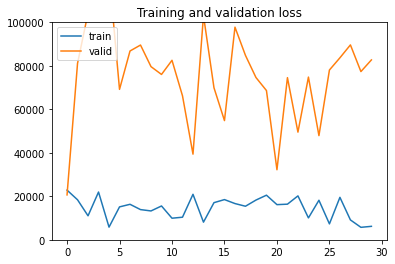

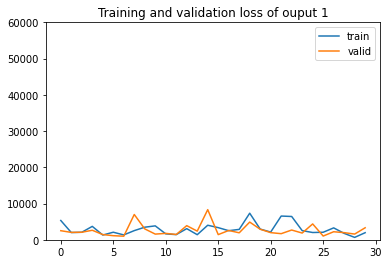

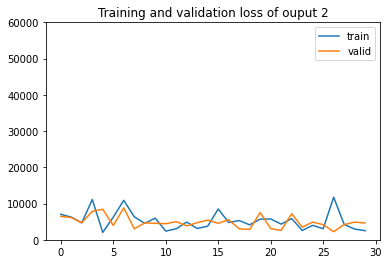

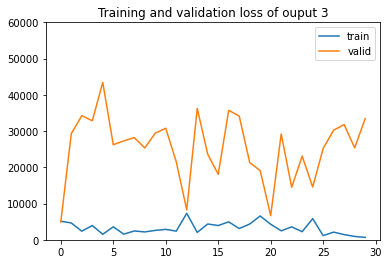

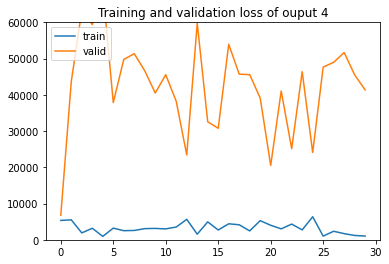

<Figure size 432x288 with 0 Axes>

In [ ]:
# Draw graphs with history list
lists=history_to_list(history)
list_to_graph(lists)

**Test**

In [ ]:
# Create flder to save tested images
!mkdir test_boxed

In [ ]:
# With prediction result, draw a predicted bounding box and ground truth box on an image
def test_model(df,orig_img_path, path_to_save_result, result):
  from matplotlib.pyplot import imshow

  ss=df['filename']
  for i in range(len(ss)):

    f_path=orig_img_path+'/'+ss[i]
    
    img=cv2.imread(f_path)
    
    # Predicted box
    box=BoundingBoxesOnImage([BoundingBox(x1=result[0][i],y1=result[1][i],x2=result[2][i],y2=result[3][i])],shape=img.shape)
    # Ground truth box
    ground_truth_box=BoundingBoxesOnImage([BoundingBox(x1=df['xmin'][i],y1=df['ymin'][i],x2=df['xmax'][i],y2=df['ymax'][i])],shape=img.shape)
    
    # Draw boxes
    img_boxed=box.draw_on_image(img, size=2, color=[0,0,255])
    img_boxed=ground_truth_box.draw_on_image(img_boxed,size=2,color=[255,0,0])

    # Save drawn image
    cv2.imwrite(path_to_save_result+'/'+ss[i],img_boxed)

In [ ]:
# Resize images for test and create Panda dataframe
df_test= dataProcess1('data/data/test','data/data/test_resized',350)

In [ ]:
# Create Image Data Generator for test
test_generator=image_datagen2('data/data/test_resized',df_test,350)

Found 236 validated image filenames.


In [ ]:
# Prediction with trained model
result=mm.predict(test_generator)

In [ ]:
# Create folder to save predicted images
!mkdir test_boxed

In [ ]:
# Draw bounding boxes with result and save those images 
test_model(df_test, 'data/data/test_resized', 'test_boxed',result)

In [ ]:
# If history is stored in a text file, use this to draw graphs
def extract_loss(line):
  lst=line.split(' ')
  result=[]
  for i in range(len(lst)):
    if 'loss:' in lst[i]:
      result.append(lst[i+1])
  return result
  
def file_to_list(filepath):
  

  f=open(filepath,'r')
  l=f.readline()
  df_result=[]
  while l:
    print(l)
    l=f.readline()

    if '82/82' in l:
      df_result.append(extract_loss(l))
  f.close()
  return df_result


def make_list_graph(idx, lst):
  result=[]
  for i in range(len(lst)):
    result.append(float(lst[i][idx]))
  return result
